In [1]:
import os
os.environ["METIS_DLL"] = "/home/budvin/research/Partitioning/metis-5.1.0/build/Linux-x86_64/libmetis/libmetis.so"


import networkx as nx
import matplotlib.pyplot as plt
import metis
import random

import pandas as pd
from collections import defaultdict 



In [2]:
def xy_to_hilbert_index (n, x,y):
    d=0
    s=n//2
    while s>0:
        rx = 1 if (x & s) > 0 else 0
        ry = 1 if (y & s) > 0 else 0
        d += s * s * ((3 * rx) ^ ry)

        # rot procedure
        if ry==0:
            if rx ==1:
                x = n-1 -x
                y = n-1 -y
            x,y = y,x

        s=s//2
    # }
    return d


In [3]:
def cluster_to_color(ci):

    # ci = (7**ci) % 100
    # tmp = hex((13*ci)**3 + (7*ci)**5)
    # part = tmp[2]+tmp[-1]
    # if ci < 10:
    #     ci+=80
    # ci_str = str(ci)
    # ci_str2 = str(ci//2)
    # return f"#{ci_str[::-1]}{ci_str2.rjust(2,'0')[::-1]}{ci_str}"
    # return f"#{part}{part[::-1]}{part[1]}{part[1]}"

    arr=['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']
    part=""
    random.seed(ci)
    # for i in range(34534,34534+6):
    #     part+=hex(ci*ci*(234567*ci*i))[-2]
    for i in range(6):
        idx = (ci*random.randint(2**10,2**26))%16
        part+=str(arr[idx])
    return f"#{part}"

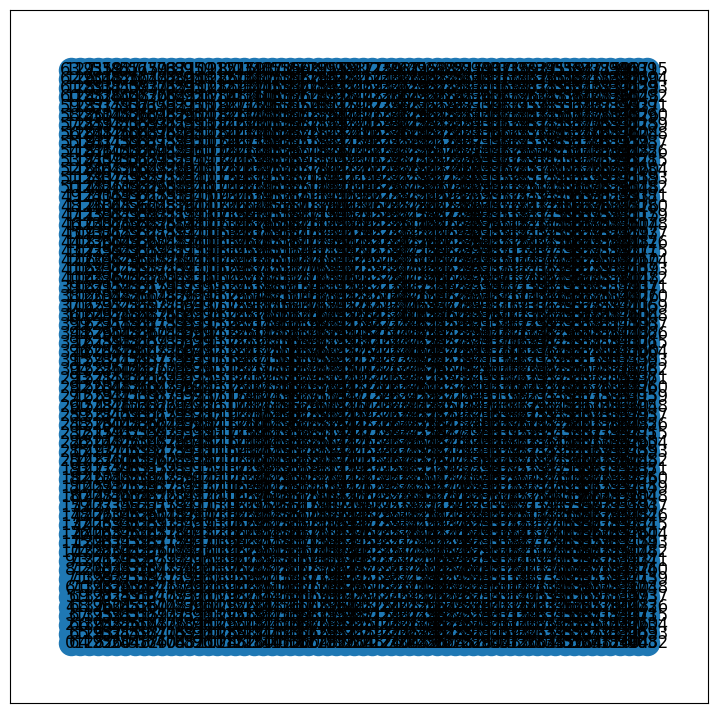

In [4]:
G = nx.Graph()
N_2_pow = 6
N = 2**N_2_pow
fig_size = 9
partition_count = 11
results = pd.DataFrame(columns=['method', 'np','lambda_expr', 'lambda','rho_expr', 'rho'])

#NxN grid
for i in range(N*N):
    G.add_node(i,pos=(i//N,i%N))

for i in range(N*N):
    x = i//N
    y = i % N
    # neighbors = [[x-1,y-1],[x-1,y],[x-1,y+1],[x,y-1],[x,y+1],[x+1,y-1],[x+1,y],[x+1,y+1]]
    neighbors = [[x-1,y],[x,y-1],[x,y+1],[x+1,y]]

    for ni in neighbors:
        if 0<=ni[0]<N and 0<=ni[1]<N:
            ni_index = N*ni[0] + ni[1]
            G.add_edge(i,ni_index)

node_count = G.number_of_nodes()
pos = nx.nx_agraph.graphviz_layout(G)
plt.figure(figsize=(fig_size,fig_size))
nx.draw_networkx(G, pos)

plt.show()

In [5]:
hilbert_labels = []
for i in range(N*N):
    x = i//N
    y = (i % N)
    hilbert_labels.append(xy_to_hilbert_index(N,x,y))

labels={}
for i in range(node_count):
    labels[i] = hilbert_labels[i]


hilbert_G = nx.Graph()

#NxN grid
for i in range(N*N):
    hilbert_G.add_node(i)


for i in range(N*N):
    for j in range(N*N):
        if (hilbert_labels[i]-hilbert_labels[j])==1:
            hilbert_G.add_edge(i,j)

# for center in centers:
#     labels[center] = str(center)
# plt.figure(figsize=(fig_size,fig_size))

# nx.draw_networkx(hilbert_G, pos,labels={})
# plt.show()

grid_in_hilbert_order:  [0, 64, 65, 1, 2, 3, 67, 66, 130, 131, 195, 194, 193, 129, 128, 192, 256, 257, 321, 320, 384, 448, 449, 385, 386, 450, 451, 387, 323, 322, 258, 259, 260, 261, 325, 324, 388, 452, 453, 389, 390, 454, 455, 391, 327, 326, 262, 263, 199, 135, 134, 198, 197, 196, 132, 133, 69, 68, 4, 5, 6, 70, 71, 7, 8, 9, 73, 72, 136, 200, 201, 137, 138, 202, 203, 139, 75, 74, 10, 11, 12, 76, 77, 13, 14, 15, 79, 78, 142, 143, 207, 206, 205, 141, 140, 204, 268, 332, 333, 269, 270, 271, 335, 334, 398, 399, 463, 462, 461, 397, 396, 460, 459, 458, 394, 395, 331, 267, 266, 330, 329, 265, 264, 328, 392, 393, 457, 456, 520, 521, 585, 584, 648, 712, 713, 649, 650, 714, 715, 651, 587, 586, 522, 523, 524, 588, 589, 525, 526, 527, 591, 590, 654, 655, 719, 718, 717, 653, 652, 716, 780, 844, 845, 781, 782, 783, 847, 846, 910, 911, 975, 974, 973, 909, 908, 972, 971, 970, 906, 907, 843, 779, 778, 842, 841, 777, 776, 840, 904, 905, 969, 968, 967, 903, 902, 966, 965, 964, 900, 901, 837, 836, 772, 77

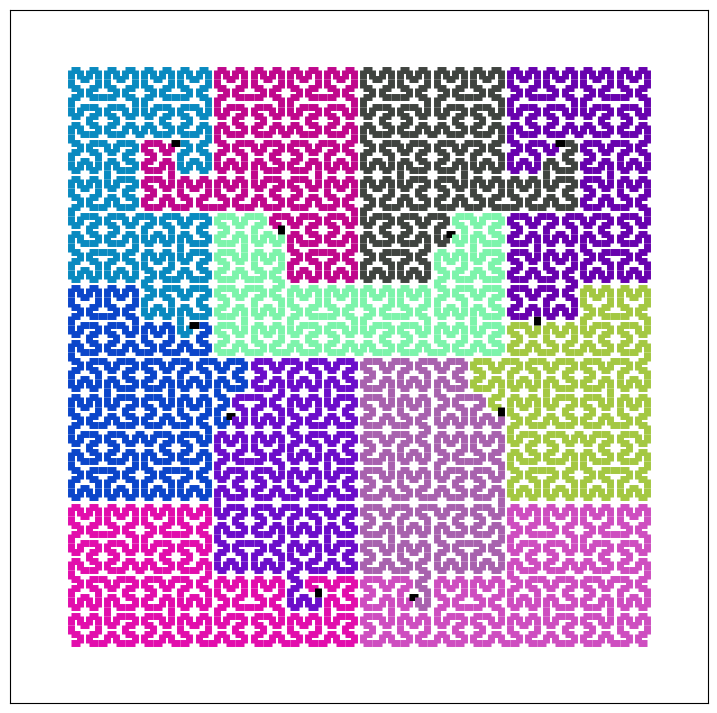

In [6]:


grid_in_hilbert_order = [ -1 for i in range(node_count)]

for grid_i,hilbert_i in enumerate(hilbert_labels):
    grid_in_hilbert_order[hilbert_i] = grid_i

print("grid_in_hilbert_order: ",grid_in_hilbert_order)

partition_size = (node_count)//partition_count

centers = []

for partition_idx in range(partition_count-1):
    x_tot = 0
    y_tot = 0
    for i in range(partition_size):
        idx = partition_size*partition_idx + i
        x = grid_in_hilbert_order[idx]//N
        y = (grid_in_hilbert_order[idx] % N)
        x_tot+=x
        y_tot+=y
    x_avg = x_tot//partition_size
    y_avg = y_tot//partition_size

    centers.append(x_avg*N+y_avg)

#handling last partition (might differ in size)
x_tot = 0
y_tot = 0
for idx in range(partition_size*(partition_count-1),node_count):
    x = grid_in_hilbert_order[idx]//N
    y = (grid_in_hilbert_order[idx] % N)
    x_tot+=x
    y_tot+=y
x_avg = x_tot//(node_count-(partition_size*(partition_count-1)))
y_avg = y_tot//(node_count-(partition_size*(partition_count-1)))

centers.append(x_avg*N+y_avg)

print("centers: ",centers)


center_labels={}
for i in range(node_count):
    center_labels[i] = ""


for c in centers:
    center_labels[c] = str(c)


hilbert_G_edges = hilbert_G.edges()
hilbert_G_edge_colors = []
for u,v in hilbert_G_edges:
    partition_u = min(hilbert_labels[u]//partition_size,partition_count-1)
    partition_v = min(hilbert_labels[v]//partition_size,partition_count-1)
    if partition_u==partition_v:
        hilbert_G_edge_colors.append(cluster_to_color(centers[partition_u]))
    else:
        hilbert_G_edge_colors.append('black')
# colors = [G[u][v]['color'] for u,v in hilbert_G_edges]

plt.figure(figsize=(fig_size,fig_size))

nx.draw_networkx_edges(hilbert_G, pos,edge_color=hilbert_G_edge_colors,width=5)
plt.show()


centers: [774, 1490, 474, 498, 1460, 2021, 2612, 3570, 3546, 2514, 3206]
labels:  [774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 49

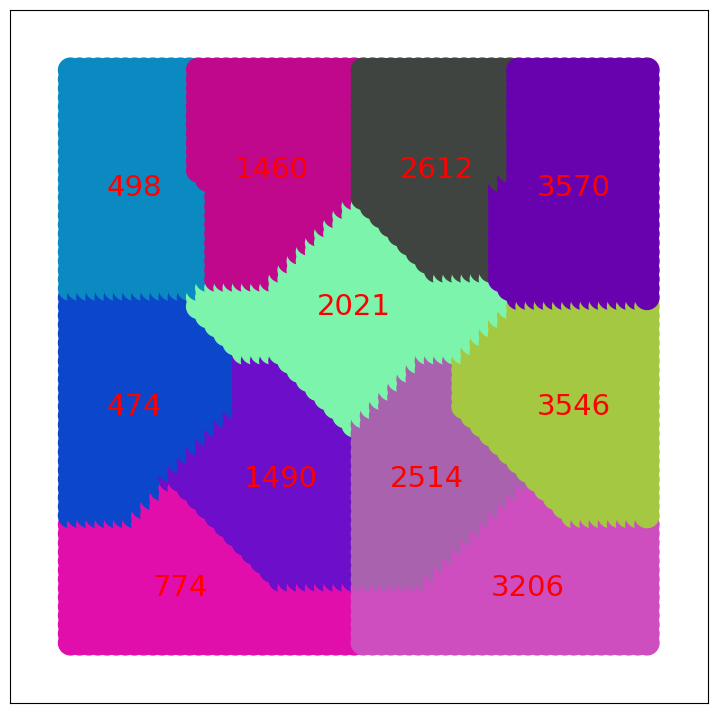

In [7]:
cluster_label = [-1 for i in range(node_count)]
cluster_distance = [float('inf') for i in range(node_count)]







for center in centers:
    li=0

    for layer in nx.bfs_layers(G,[center]):
        if li==0:
            cluster_label[layer[0]] = center
            cluster_distance[layer[0]] = 0
            li+=1
            continue

        # print(layer)
        for x in layer:
            if li < cluster_distance[x]:
                cluster_label[x] = center
                cluster_distance[x] = li
        li+=1
print("centers:", centers)
print("labels: ", cluster_label)
# pos = nx.nx_agraph.graphviz_layout(G)
plt.figure(figsize=(fig_size,fig_size))
node_color=[cluster_to_color(c) for c in cluster_label]
labels={}
for i in range(node_count):
    labels[i] = ""

for center in centers:
    labels[center] = str(center)
nx.draw_networkx(G, pos,cluster_label,node_color=node_color,labels=labels,font_color='red',font_size=21)
plt.show()

In [8]:
partition_sizes = defaultdict(int)
for cl in cluster_label:
    partition_sizes[cl]+=1

edge_cuts = 0

for u,v in G.edges:
    if cluster_label[u] != cluster_label[v]:
        edge_cuts+=1
# 'method', 'np', 'lambda', 'rho'
rho = max(partition_sizes.values())/(G.number_of_nodes()/partition_count)
lmb = edge_cuts/G.number_of_edges()
s = pd.Series({'method':'SFC BFS', 'np':partition_count,'lambda_expr':f"{edge_cuts}/{G.number_of_edges()}",'lambda': lmb,'rho_expr':f"{max(partition_sizes.values())}/{int(G.number_of_nodes()/partition_count)}",'rho':rho})
print(edge_cuts)
results = pd.concat([results, pd.DataFrame([s])],ignore_index=True)

377


/tmp/ipykernel_20257/3850095344.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([s])],ignore_index=True)


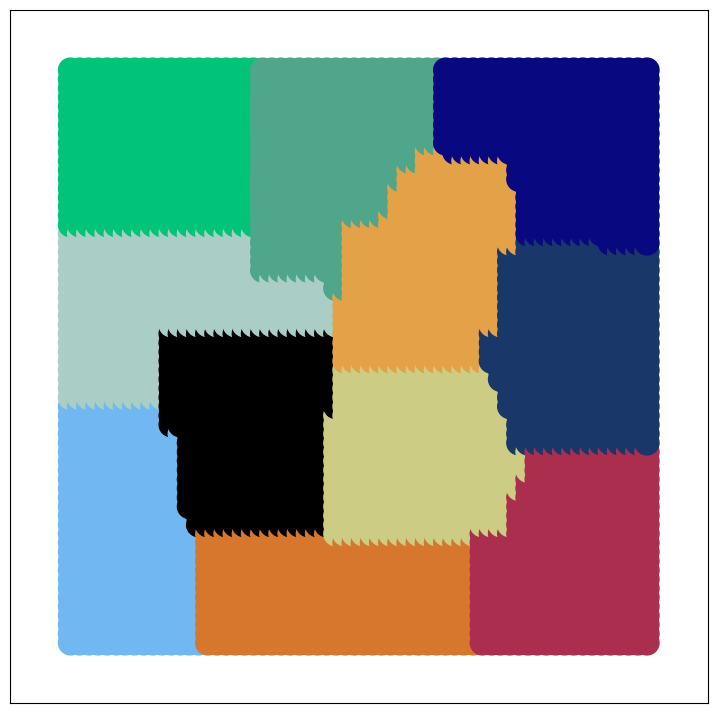

In [9]:
(edgecuts, metis_parts_labels) = metis.part_graph(G, partition_count)
node_color_metis=[cluster_to_color(c) for c in metis_parts_labels]
labels_metis = {}
plt.figure(figsize=(fig_size,fig_size))
nx.draw_networkx(G, pos,node_color=node_color_metis,labels=labels_metis)
plt.show()


In [10]:
partition_sizes_metis = defaultdict(int)
for cl in metis_parts_labels:
    partition_sizes_metis[cl]+=1

edge_cuts_metis = 0

for u,v in G.edges:
    if metis_parts_labels[u] != metis_parts_labels[v]:
        edge_cuts_metis+=1
# 'method', 'np', 'lambda', 'rho'
rho_metis = max(partition_sizes_metis.values())/(G.number_of_nodes()/partition_count)
lmb_metis = edge_cuts_metis/G.number_of_edges()
s = pd.Series({'method':'METIS', 'np':partition_count,'lambda_expr':f"{edge_cuts_metis}/{G.number_of_edges()}",'lambda': lmb_metis,'rho_expr':f"{max(partition_sizes_metis.values())}/{int(G.number_of_nodes()/partition_count)}",'rho':rho_metis})

results = pd.concat([results, pd.DataFrame([s])],ignore_index=True)

In [11]:
print(results)

    method  np lambda_expr    lambda rho_expr       rho
0  SFC BFS  11    377/8064  0.046751  414/372  1.111816
1    METIS  11    341/8064  0.042287  381/372  1.023193
